# Exploration15: 한국어 데이터로 챗봇 만들기
챗봇 데이터는 송영숙 님이 공개한 챗봇 데이터를 사용합니다.

## Step1. 데이터 로드하기

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel/Exploration/Exploration15/ChatbotData.csv'
data = pd.read_csv(file_path)
print(data.shape)
data.head(15)

(11823, 3)


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


## Step 2. 데이터 전처리하기

전처리는 정규표현식(Regular Expression)을 사용하여 구두점(punctuation)을 제거하며 단어를 토크나이징(tokenizing)하는 일에 방해가 되지 않도록 만드는 것을 목표로 합니다.

데이터를 로드하는 동시에 전처리 함수를 호출하여 질문과 답변의 쌍을 전처리합니다.

In [4]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^ㄱ-ㅣ가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [5]:
questions = data['Q']
questions = questions.values

answers = data['A']
answers = answers.values

print(questions)
print(answers)

['12시 땡!' '1지망 학교 떨어졌어' '3박4일 놀러가고 싶다' ... '흑기사 해주는 짝남.'
 '힘든 연애 좋은 연애라는게 무슨 차이일까?' '힘들어서 결혼할까봐']
['하루가 또 가네요.' '위로해 드립니다.' '여행은 언제나 좋죠.' ... '설렜겠어요.'
 '잘 헤어질 수 있는 사이 여부인 거 같아요.' '도피성 결혼은 하지 않길 바라요.']


In [6]:
questions = list(map(preprocess_sentence, questions))
questions[:10]

['12시 땡 !',
 '1지망 학교 떨어졌어',
 '3박4일 놀러가고 싶다',
 '3박4일 정도 놀러가고 싶다',
 'ppl 심하네',
 'sd카드 망가졌어',
 'sd카드 안돼',
 'sns 맞팔 왜 안하지ㅠㅠ',
 'sns 시간낭비인 거 아는데 매일 하는 중',
 'sns 시간낭비인데 자꾸 보게됨']

In [7]:
answers = list(map(preprocess_sentence, answers))
answers[:10]

['하루가 또 가네요 .',
 '위로해 드립니다 .',
 '여행은 언제나 좋죠 .',
 '여행은 언제나 좋죠 .',
 '눈살이 찌푸려지죠 .',
 '다시 새로 사는 게 마음 편해요 .',
 '다시 새로 사는 게 마음 편해요 .',
 '잘 모르고 있을 수도 있어요 .',
 '시간을 정하고 해보세요 .',
 '시간을 정하고 해보세요 .']

In [8]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


## Step 3. SubwordTextEncoder 사용하기

### 병렬 데이터 전처리하기
질문과 답변의 셋을 각각 question과 answers에 저장했으므로 전처리를 진행합니다.  
1. TensorFlow Dataset SubwordTextEncoder를 토크나이저로 사용한다. 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고 각 토큰을 고유한 정수로 인코딩한다.  
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.  
3. 최대 길이 MAX_LENGTH를 넘을 문장들은 필터링한다.  
4. MAX_LENGTH보다 짧은 문장들은 MAX_LENGTH에 맞도록 한다.

단어장 만들기  
각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary)을 만듭니다. 단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만듭니다.  
한국어 데이터는 형태소 분석기를 사용해 토크나이징을 진행하지만 여기서는 형태소 분석기가 아닌 내부 단어 토크나이저인 SubwordTextEncoder를 사용하겠습니다.

In [9]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary생성.
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions+answers, target_vocab_size=2**13)

In [10]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [11]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]


각각 8170과 8171라는 점에서 현재 단어장의 크기가 8170(0번부터 8169번)이라는 의미입니다.  
두 개의 토큰을 추가해 주었기 때문에 단어장의 크기도 +2임을 명시해 주어야 합니다.

In [12]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


### 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있습니다.

In [13]:
# 사용 예시. 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5761, 610, 2490, 4163]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7510, 7, 6273, 97, 1]


각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있습니다.  
위의 결과와 마찬가지로 질문과 답변 셋에 대해서 전부 정수 인코딩을 수행합니다. 동시에 문장의 최대 길이를 정하고 해당 길이로 패딩(padding)합니다.

In [14]:
questions_len = [len(i.split()) for i in questions]
answers_len = [len(i.split()) for i in answers]

In [15]:
print('질문의 최소 길이: {}'.format(np.min(questions_len)))
print('질문의 최대 길이: {}'.format(np.max(questions_len)))
print('질문의 평균 길이: {}'.format(np.mean(questions_len)))

print('답변의 평균 길이: {}'.format(np.min(answers_len)))
print('답변의 평균 길이: {}'.format(np.max(answers_len)))
print('답변의 평균 길이: {}'.format(np.mean(answers_len)))

질문의 최소 길이: 1
질문의 최대 길이: 16
질문의 평균 길이: 3.9409625306605767
답변의 평균 길이: 1
답변의 평균 길이: 24
답변의 평균 길이: 4.716146494121627


In [16]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 26
print(MAX_LENGTH)

26


In [17]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [18]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11819
필터링 후의 답변 샘플 개수: 11819


## Step 4. 모델 구성하기

### 포지셔널 인코딩 레이어(Positional Encoding Layer)
트랜스포머는 덱스트 문장을 입력으로 받기 위해 단어를 임베딩 벡터로 변환하는 벡터화 과정을 거칩니다.  
하지만 트랜스포머 모델은 임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용한다는 점에서 다른 모델과 다릅니다.이는 포지셔널 인코딩(Prositional Encoding)에 해당하는 부분입니다.  
문장의 모든 단어를 한꺼번에 문장 단위로 입력받는 트랜스포머는 'I ate lunch'와 'lunch ate I'를 구분할 수 없을 수 있기에 같은 단어라도 그 단어가 문장의 몇 번째 어순으로 입력되었는지를 알려주기 위해 위치 정보를 가진 벡터(Positional Encoding)값을 더해서 모델의 입력으로 삼는 것입니다.

In [19]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

행의 크기가 50, 열의 크기가 512인 행렬을 만들어 봅니다.  
이는 최대 문장의 길이가 50이고 워드 임베딩 차원이 512인 모델의 입력 벡터 모양과 같습니다.

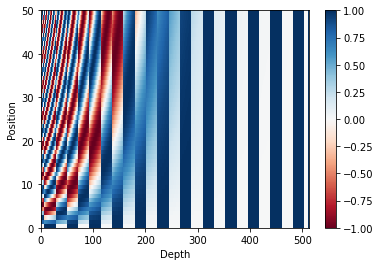

In [20]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 어텐션 메커니즘
어텐션 함수는 주어진 쿼리(Query)에 대해서 모든 키(Key)와의 유사도를 각각 구합니다. 이후 구해낸 유사도를 키와 맵핑되어있는 각각의 값(Value)에 반영해 줍니다.  
그리고 유사도가 반영된 값을 모두 더해서 뭉쳐주면 최종 결과인 어텐션 값(Attention Value)를 얻을 수 있습니다.

트랜스포머는 총 세 가지 어텐션을 사용합니다.
* 첫번째: 인코더 셀프 어텐션은 인코더에서 이루어지고
* 두번째: 디코더 셀프 어텐션은 디코더에서 이루어지며
* 세번째: 인코더-디코더 어텐션 또한 디코더에서 이루어집니다.

트랜스포머의 어텐션 함수에 사용되는 쿼리(Query), 키(Key), 벨류(Value)는 기본적으로 '단어(정보를 함축한)벡터'입니다.  
이 단어벡터란 초기 입력으로 사용되었던 임베딩 벡터가 아닌 트랜스포머의 여러 연산을 거친 후의 단어벡터 입니다.  
그럼 위 세 가지 어텐션이 하는 일을 조금 더 자세히 알아보겠습니다.
* 인코더 셀프 어텐션: 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.
* 디코더 셀프 어텐션: 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
* 인코더-디코더 어텐션: 디코더가 잘 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.

**셀프 어텐션(Self Attention)**  
셀프 어텐션이란 다른 문장의 단어가 아닌 현재 문장 내의 단어들이 서로 유사도를 구하는 것을 의미합니다.  
The animal didn't cross the street bacause it was too tired.  
여기서 It은 animal을 지칭하는데, 기계는 그렇지 않습니다. 셀프 어텐션은 문장 내의 단어들끼리 유사도를 구하여 it이 animal과 연관되었을 확률이 높다는 것을 찾아냅니다.

**스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention)**  
문장행렬Q * 문장행렬K = 유사도 행렬 (단어 벡터의 유사도가 기록된 행렬)  
softmax((유사도 행렬 / 차원 수 (Normalization) ) * 문장행렬V) = 어텐션 값 

In [21]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

**병렬로 어텐션 수행하기**  
트랜스포머에서 num_heads라는 변수는 기계가 몇 개의 병렬적인 어텐션 연산을 수행할지 결정하는 파라미터입니다.  
트랜스포머의 초기 입력인 문장 행렬의 크기는 문장의 길이를 행으로, d_model을 열의 크기로 가집니다. 이렇게 입력된 문장 행렬을 num_heads의 수만큼 쪼개서 어텐션을 수행하고, 각각의 값 행렬을 다시 하나로 concatenate합니다.  
이렇게 함으로써 it라는 토큰을 animal, sreet이라고 보는 각각의 관점을 한꺼번에 얻을 수 있습니다.  
이처럼 어텐션을 병렬로 수행하는 것을 멀티 헤드 어텐션이라고 부릅니다.

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                              (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

### 마스킹
마스킹(Masking)은 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법입니다.  
트랜스포머에서는 어텐션을 위해 크게 두 가지 마스킹을 사용합니다.

**패딩 마스킹(Padding masking)**  
0으로 이루어진 패딩은 실제 의미가 있는 다넝가 아니므로 어텐션 연산에서는 제외할 필요가 있습니다.  
패딩 마스킹은 이를 위해 숫자 0인 위치를 체크합니다.

In [23]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

이 함수에 정수 시퀀스를 입력으로 하면 숫자가 0인 부분을 체크한 벡터를 리턴합니다.

In [24]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


**룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)**  
RNN과 트랜스포머는 문장을 입력받는 방법이 전혀 다릅니다.  
RNN은 각 step마다 단어가 순서대로 입력으로 들어가는 반면 트랜스포머의 경우 문장 행렬을 만들어 한 번에 행렬 형태의 입력이 들어갑니다.  
우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 것이기 때문에 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩어헤드 마스킹 기법입니다.

In [25]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [26]:
# 테스트
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [27]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 인코더
하나의 인코더 층은 크게 총 2개의 서브층(sublayer)으로 나누어집니다.  
그것은 셀프 어텐션과 피드 포워드 신경망인데, 셀프어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어집니다.

In [28]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

**인코더 층을 쌓아 인코더 만들기**  
인코더 층을 임베딩 층과 포지셔널 인코딩을 연결하고 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성됩니다.  
인코더와 디코더 내부에는 각 서브 층 이후에 훈련을 돕는 Layer Normalization이라는 테크닉이 사용되었습니다.  
트랜스포머는 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓습니다. 학습시간을 고려해 적은 개수를 사용하겠습니다.

In [29]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
            )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더
디코더는 인코더와 비슷하지만 세 개의 서브 층으로 구성된다는 점에서 조금 더 복잡합니다.
1. 셀프 어텐션  
2. 인코더-디코더 어텐션  
3. 피드 포워드 신경망  
인코더-디코더 어텐션은 셀프 어텐션과는 달리 Query가 디코더의 벡터인 반면 Key와 Value가 인코더의 벡터라는 특징이 있습니다. 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정입니다.  
인코더의 셀프 어텐션과 마찬가지로 디코더의 셀프 어텐션, 인코더-디코더 어텐션, 두 가지 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행합니다.

In [30]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

**디코더 층을 쌓아 디코더 만들기**  
디코더의 층은 임베딩 층(Embedding layer)과 포지셔널 인코딩(Positional Encoding)을 연결하고 디코더 층을 쌓아 만듭니다.  
위의 인코더와 유사하게 구성해 줍니다.

In [31]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### 모델 정의 및 학습하기
인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의합니다.

In [32]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

**모델 생성**  
num_layers, d-model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터 값입니다.  
실제 사용되는 것보다 작은 값을 사용하겠습니다.

In [33]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3146240     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

**손실함수(Loss function)**  
레이블인 시퀀스에 패딩이 되어 있으므로 loss를 계산할 때 패딩 마스크를 적용해야 합니다.

In [42]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

**커스텀 된 학습률(Learning rate)**  
딥러닝 모델 학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다.  
커스텁 학습률 스케쥴링(Custom Learning rate Scheduling)을 사용하면 적합한 lr을 찾을 수 있습니다.

In [43]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

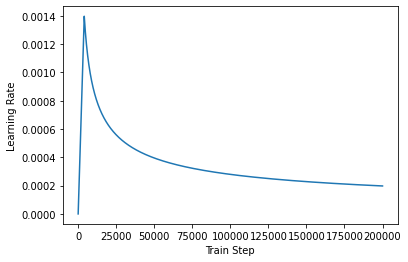

In [44]:
# lr 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

**모델 컴파일**  
손실 함수와 커스텀 된 학습률을 사용하여 모델을 컴파일 합니다.

In [45]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_ture = tf.reshape(y_true, shape=(-1, MAX_LENGTH -1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

**교사 강요(Teacher Forcing) 사용하기**  
tf.data.Dataset API는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API입니다.  
이를 사용하기 위해서 질문과 답변의 쌍을 tf.data.Dataset의 입력으로 넣어주는 작업을 합니다.  
이 때 디코거의 입력과 실제값(레이블)을 정의해 주기 위해서는 교사 강요(Teacher Forcing) 언어 모델의 훈련 기법을 사용합니다.

질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성합니다. 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용합니다.

In [53]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [54]:
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
185/185 [==============================] - 16s 89ms/step - loss: 1.3810 - accuracy: 0.0883
Epoch 2/30
185/185 [==============================] - 16s 88ms/step - loss: 1.2863 - accuracy: 0.0947
Epoch 3/30
185/185 [==============================] - 16s 88ms/step - loss: 1.1842 - accuracy: 0.1040
Epoch 4/30
185/185 [==============================] - 16s 88ms/step - loss: 1.0721 - accuracy: 0.1155
Epoch 5/30
185/185 [==============================] - 16s 88ms/step - loss: 0.9525 - accuracy: 0.1283
Epoch 6/30
185/185 [==============================] - 16s 89ms/step - loss: 0.8275 - accuracy: 0.1425
Epoch 7/30
185/185 [==============================] - 16s 88ms/step - loss: 0.6998 - accuracy: 0.1578
Epoch 8/30
185/185 [==============================] - 16s 88ms/step - loss: 0.5742 - accuracy: 0.1744
Epoch 9/30
185/185 [==============================] - 16s 88ms/step - loss: 0.4550 - accuracy: 0.1917
Epoch 10/30
185/185 [==============================] - 16s 88ms/step - loss: 0.349

## Step 5. 모델 평가하기
예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.  
1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.  
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [55]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sentence = tf.expand_dims(
    START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장.
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만듭니다.

In [56]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴 받습니다.
    prediction = decoder_inference(sentence)
    
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])
    
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))
    
    return predicted_sentence

In [68]:
sentence_generation('비오는데 너무 심심해. 할 거 없나?')

입력 : 비오는데 너무 심심해. 할 거 없나?
출력 : 노래 불러 드릴까요 ? 북치기박치기 헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥


'노래 불러 드릴까요 ? 북치기박치기 헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥'

In [69]:
sentence_generation('큰 북을 울려라 둥둥둥')

입력 : 큰 북을 울려라 둥둥둥
출력 : 상처받고 있다고 말해보세요 .


'상처받고 있다고 말해보세요 .'

In [70]:
sentence_generation('상처받고 있어 너 때문에')

입력 : 상처받고 있어 너 때문에
출력 : 먼저 다가가는 건 어떨까요 .


'먼저 다가가는 건 어떨까요 .'

In [71]:
sentence_generation('도대체 무슨 소리를 하는거야')

입력 : 도대체 무슨 소리를 하는거야
출력 : 당신이 사랑이라고 생각하는 경향이 있나 봅니다 .


'당신이 사랑이라고 생각하는 경향이 있나 봅니다 .'

In [72]:
sentence_generation('우리는 이루어질 수 없는 사이야 미안해')

입력 : 우리는 이루어질 수 없는 사이야 미안해
출력 : 이제 짝사랑 말고 둘이서 하는 사랑하세요 .


'이제 짝사랑 말고 둘이서 하는 사랑하세요 .'